In [ ]:
!git clone https://github.com/shaoanlu/GazeML-keras.git

In [ ]:
%cd "GazeML-keras"

In [1]:
# CPU inference
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from detector.face_detector import MTCNNFaceDetector
from models.elg_keras import KerasELG
from keras import backend as K

import numpy as np
import cv2
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Instantiate face detector

We apply MTCNN for face and 5-points landmarks detection.

In [3]:
mtcnn_weights_dir = "./mtcnn_weights/"
fd = MTCNNFaceDetector(sess=K.get_session(), model_path=mtcnn_weights_dir)

## Instantiate GazeML ELG model

A stacked hourglass framework for iris and eye-lid detection.

In [4]:
model = KerasELG()
model.net.load_weights("./elg_weights/elg_keras.h5")

## Load image

In [52]:
fn = "./test_imgs/Lenna_(test_image).png"
input_img = cv2.imread(fn)[..., ::-1]

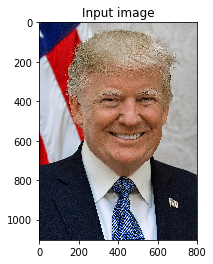

In [53]:
plt.title('Input image')
plt.imshow(input_img)

## Apply face detection

Input: RGB image

Outputs: face bounding box and 5-points landmarks

In [54]:
face, lms = fd.detect_face(input_img) # assuming there is only one face in input image
assert len(face) >= 1, "No face detected"

## Visualize eyes detection

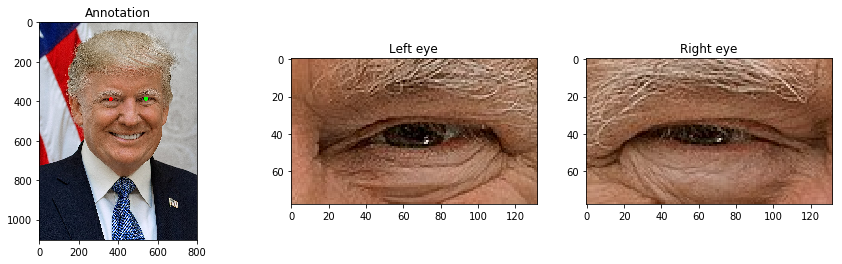

In [55]:
left_eye_xy = np.array([lms[6], lms[1]])
right_eye_xy = np.array([lms[5], lms[0]])

dist_eyes = np.linalg.norm(left_eye_xy - right_eye_xy)
eye_bbox_w = (dist_eyes / 1.25)
eye_bbox_h = (eye_bbox_w *0.6)

left_eye_im = input_img[
    int(left_eye_xy[0]-eye_bbox_h//2):int(left_eye_xy[0]+eye_bbox_h//2),
    int(left_eye_xy[1]-eye_bbox_w//2):int(left_eye_xy[1]+eye_bbox_w//2), :]
#left_eye_im = left_eye_im[:,::-1,:] # No need for flipping left eye for iris detection
right_eye_im = input_img[
    int(right_eye_xy[0]-eye_bbox_h//2):int(right_eye_xy[0]+eye_bbox_h//2),
    int(right_eye_xy[1]-eye_bbox_w//2):int(right_eye_xy[1]+eye_bbox_w//2), :]

plt.figure(figsize=(15,4))
draw = input_img.copy()
for i, lm in enumerate([left_eye_xy, right_eye_xy]):
    draw = cv2.circle(draw, (int(lm[1]), int(lm[0])), 10, (255*i,255*(1-i),0), -1)
plt.subplot(1,3,1)
plt.title('Annotation')
plt.imshow(draw)
plt.subplot(1,3,2)
plt.title('Left eye')
plt.imshow(left_eye_im)
plt.subplot(1,3,3)
plt.title('Right eye')
plt.imshow(right_eye_im)

## Preprocess eye images

ELG has fixed input shape of (108, 180, 1).

Input images are first converted to grey scale, thrown into the histogram equalization process, and finally rescaled to [-1, +1]. 

In [56]:
inp_left = cv2.cvtColor(left_eye_im, cv2.COLOR_RGB2GRAY)
inp_left = cv2.equalizeHist(inp_left)
inp_left = cv2.resize(inp_left, (180,108))[np.newaxis, ..., np.newaxis]

inp_right = cv2.cvtColor(right_eye_im, cv2.COLOR_RGB2GRAY)
inp_right = cv2.equalizeHist(inp_right)
inp_right = cv2.resize(inp_right, (180,108))[np.newaxis, ..., np.newaxis]

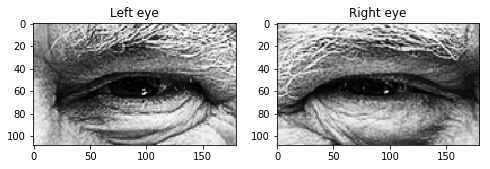

In [57]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title('Left eye')
plt.imshow(inp_left[0,...,0], cmap="gray")
plt.subplot(1,2,2)
plt.title('Right eye')
plt.imshow(inp_right[0,...,0], cmap="gray")

## Predict eye region landmarks

ELG forwardpass. Output shape: (36, 60, 18)

In [58]:
inp_left.shape, inp_right.shape

((1, 108, 180, 1), (1, 108, 180, 1))

In [59]:
input_array = np.concatenate([inp_left, inp_right], axis=0)
pred_left, pred_right = model.net.predict(input_array/255 * 2 - 1)

## Visualize output heatmaps

Eighteen heatmaps are predicted: 
- Eight heatmaps for iris (green)
- Eight heatmaps for eye-lid (red)
- Two heatmaps for pupil (blue)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


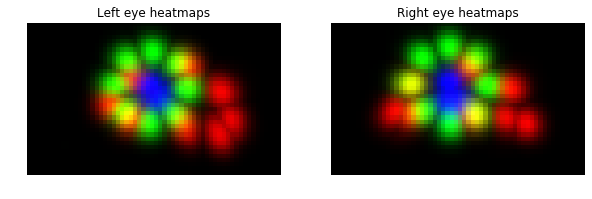

In [60]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Left eye heatmaps')
hm_r = np.max(pred_left[...,:8], axis=-1, keepdims=True)
hm_g = np.max(pred_left[...,8:16], axis=-1, keepdims=True)
hm_b = np.max(pred_left[...,16:], axis=-1, keepdims=True)
plt.imshow(np.concatenate([hm_r, hm_g, hm_b], axis=-1))
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Right eye heatmaps')
hm_r = np.max(pred_right[...,:8], axis=-1, keepdims=True)
hm_g = np.max(pred_right[...,8:16], axis=-1, keepdims=True)
hm_b = np.max(pred_right[...,16:], axis=-1, keepdims=True)
plt.imshow(np.concatenate([hm_r, hm_g, hm_b], axis=-1))

# Draw eye region landmarks

In [61]:
def draw_pupil(im, inp_im, lms):
    draw = im.copy()
    draw = cv2.resize(draw, (inp_im.shape[2], inp_im.shape[1]))
    pupil_center = np.zeros((2,))
    pnts_outerline = []
    pnts_innerline = []
    stroke = inp_im.shape[1] // 12 + 1
    for i, lm in enumerate(np.squeeze(lms)):
        #print(lm)
        y, x = int(lm[0]*3), int(lm[1]*3)

        if i < 8:
            draw = cv2.circle(draw, (y, x), stroke, (125,255,125), -1)
            pnts_outerline.append([y, x])
        elif i < 16:
            draw = cv2.circle(draw, (y, x), stroke, (125,125,255), -1)
            pnts_innerline.append([y, x])
            pupil_center += (y,x)
        elif i < 17:
            draw = cv2.drawMarker(draw, (y, x), (255,200,200), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=stroke, line_type=cv2.LINE_AA)
        else:
            draw = cv2.drawMarker(draw, (y, x), (255,125,125), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=stroke, line_type=cv2.LINE_AA)
    pupil_center = (pupil_center/8).astype(np.int32)
    draw = cv2.cv2.circle(draw, (pupil_center[0], pupil_center[1]), stroke, (255,255,0), -1)        
    draw = cv2.polylines(draw, [np.array(pnts_outerline).reshape(-1,1,2)], isClosed=True, color=(125,255,125), thickness=stroke//2)
    draw = cv2.polylines(draw, [np.array(pnts_innerline).reshape(-1,1,2)], isClosed=True, color=(125,125,255), thickness=stroke//2)
    return draw

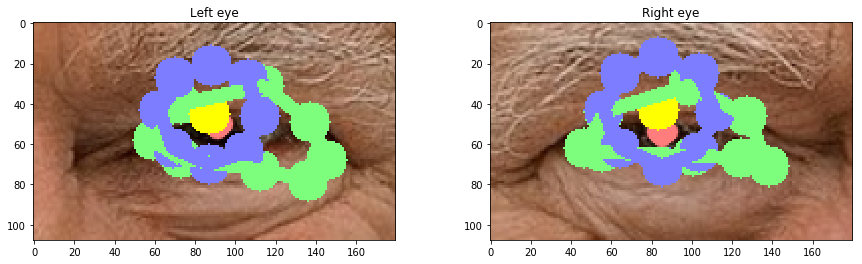

In [62]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Left eye")
lms_left = model._calculate_landmarks(pred_left)
result_left = draw_pupil(left_eye_im, inp_left, lms_left)
plt.imshow(result_left)
plt.subplot(1,2,2)
plt.title("Right eye")
lms_right = model._calculate_landmarks(pred_right)
result_right = draw_pupil(right_eye_im, inp_right, lms_right)
plt.imshow(result_right)

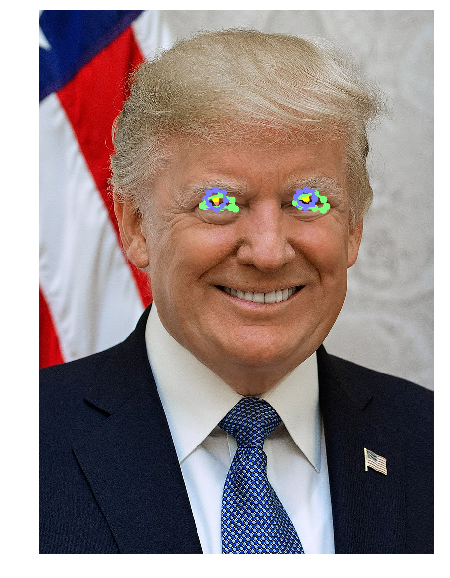

In [63]:
draw2 = input_img.copy()

slice_h = slice(int(left_eye_xy[0]-eye_bbox_h//2), int(left_eye_xy[0]+eye_bbox_h//2))
slice_w = slice(int(left_eye_xy[1]-eye_bbox_w//2), int(left_eye_xy[1]+eye_bbox_w//2))
im_shape = left_eye_im.shape[::-1]

draw2[slice_h, slice_w, :] = cv2.resize(result_left, im_shape[1:])

slice_h = slice(int(right_eye_xy[0]-eye_bbox_h//2), int(right_eye_xy[0]+eye_bbox_h//2))
slice_w = slice(int(right_eye_xy[1]-eye_bbox_w//2), int(right_eye_xy[1]+eye_bbox_w//2))
im_shape = right_eye_im.shape[::-1]

draw2[slice_h, slice_w, :] = cv2.resize(result_right, im_shape[1:])

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(draw2)